# Distributed Road Erosion Model Tutorial

In this tutorial, we run the full distributed road erosion model (i.e., all three components discussed in the README!) to get an estimate of annual sediment load from the road. 

### Load necessary `python` packages and set some defaults

In [1]:
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from landlab import RasterModelGrid 
from landlab.io import native_landlab
from landlab.components import TruckPassErosion
from landlab.components import FlowAccumulator, FastscapeEroder
from landlab.plot.imshow import imshow_grid
from landlab.plot.drainage_plot import drainage_plot

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'normal'

np.set_printoptions(threshold=np.inf)

### Creating a synthetic grid

For this tutorial, we're going to create a synthetic grid (i.e., make our own DEM!) with a ditch line. We're going to develop a `python` function so we can easily change node spacing depending on whether we're using a node size of a full-tire width or a half-tire-width. We'll call `ErodibleGrid` before we run our full model.

Within `ErodibleGrid`, we call Landlab's `RasterModelGrid` to create a raster grid, and we add a few fields to the grid (e.g., `'topographic__elevation'`, `'roughness'`) with data.

In [2]:
def ErodibleGrid(nrows, ncols, spacing, full_tire):
    mg = RasterModelGrid((nrows,ncols),spacing)
    z = mg.add_zeros('topographic__elevation', at='node') #create the topographic__elevation field
    road_flag = mg.add_zeros('flag', at='node') #create a road_flag field for determining whether a 
                                                #node is part of the road or the ditch line
    n = mg.add_zeros('roughness', at='node') #create roughness field
    

    mg.set_fixed_value_boundaries_at_grid_edges(False, False, False, True)     
    mg.set_closed_boundaries_at_grid_edges(False, False, False, False) 
    
    if full_tire == False: #When node spacing is half-tire-width
        road_peak = 40 #peak crowning height occurs at this x-location
        up = 0.0067 #rise of slope from ditchline to crown
        down = 0.0067 #rise of slope from crown to fillslope
        
        for g in range(nrows): #loop through road length
            elev = 0 #initialize elevation placeholder
            flag = False #initialize road_flag placeholder
            roughness = 0.1 #initialize roughness placeholder   

            for h in range(ncols): #loop through road width
                if h == 0 or h == 8:
                    elev = 0
                    flag = False
                    roughness = 0.1
                elif h == 1 or h == 7:
                    elev = -0.333375
                    flag = False
                    roughness = 0.1
                elif h == 2 or h == 6:
                    elev = -0.5715
                    flag = False
                    roughness = 0.1
                elif h == 3 or h == 5:
                    elev = -0.714375
                    flag = False
                    roughness = 0.1
                elif h == 4:
                    elev = -0.762
                    flag = False
                    roughness = 0.1
                elif h <= road_peak and h > 8: #update latitudinal slopes based on location related to road_peak
                    elev += up
                    flag = True
                    roughness = 0.05
                else:
                    elev -= down
                    flag = True
                    roughness = 0.05

                z[g*ncols + h] = elev #update elevation based on x & y locations
                road_flag[g*ncols+h] = flag #update road_flag based on x & y locations
                n[g*ncols + h] = roughness #update roughness values based on x & y locations
    elif full_tire == True: #When node spacing is full-tire-width
        road_peak = 20 #peak crowning height occurs at this x-location
        up = 0.0134 #rise of slope from ditchline to crown
        down = 0.0134 #rise of slope from crown to fillslope
        
        for g in range(nrows): #loop through road length
            elev = 0 #initialize elevation placeholder
            flag = False #initialize road_flag placeholder
            roughness = 0.1 #initialize roughness placeholder

            for h in range(ncols): #loop through road width
                if h == 0 or h == 4:
                    elev = 0
                    flag = False
                    roughness = 0.1
                elif h == 1 or h == 3:
                    elev = -0.5715
                    flag = False
                    roughness = 0.1
                elif h == 2:
                    elev = -0.762
                    flag = False
                    roughness = 0.1
                elif h <= road_peak and h > 4: #update latitudinal slopes based on location related to road_peak
                    elev += up
                    flag = True
                    roughness = 0.05
                else:
                    elev -= down
                    flag = True
                    roughness = 0.05

                z[g*ncols + h] = elev #update elevation based on x & y locations
                road_flag[g*ncols+h] = flag #update road_flag based on x & y locations
                n[g*ncols + h] = roughness #update roughness values based on x & y locations
        
    z += mg.node_y*0.05 #add longitudinal slope to road segment
    road_flag = road_flag.astype(bool) #Make sure road_flag is a boolean array
                
    return(mg, z, road_flag, n)          


### 1. Create grid using half-tire-width node spacing

We'll first call `ErodibleGrid` with the values needed to create a synthetic grid that is ~80m long by ~10.5m wide (including the ditch line) using half-tire-width node spacing (~0.15m). We'll also add small perturbations to the road surface such that there is a slightly more interesting topography.

In [3]:
np.random.seed(7)

mg, z, road_flag, n = ErodibleGrid(540,72,0.1475,False) #half tire width
noise_amplitude=0.007

z[road_flag==1] += noise_amplitude * np.random.rand(
    len(z[road_flag==1])
)

#add depth fields that will update in the component
mg.at_node['active__depth'] = np.ones(540*72)*0.02
mg.at_node['surfacing__depth'] = np.ones(540*72)*0.23
mg.at_node['ballast__depth'] = np.ones(540*72)*2.0

#add absolute elevation fields that will update based on z updates
mg.at_node['active__elev'] = z
mg.at_node['surfacing__elev'] = z - mg.at_node['active__depth']
mg.at_node['ballast__elev'] = z - mg.at_node['active__depth']\
     - mg.at_node['surfacing__depth']

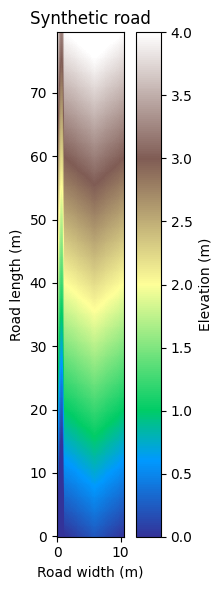

In [4]:
# Plot the initial surface
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
imshow_grid(mg, z, plot_name='Synthetic road', var_name='Elevation', var_units='m',\
    grid_units=('m', 'm'), cmap='terrain', color_for_closed='black', vmin=0, vmax=4)
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

In [5]:
# Prepare some variables for later
xsec_pre = mg.at_node['topographic__elevation'][4392*2:4428*2].copy() #half tire width
mg_pre = mg.at_node['topographic__elevation'].copy()
active_pre = mg.at_node['active__depth'].copy()

X = mg.node_x.reshape(mg.shape)
Y = mg.node_y.reshape(mg.shape)
Z = z.reshape(mg.shape)

### 2. Instantiate the components

Next, we need to instantiate all three components that we'll be running:
1. `TruckPassErosion` - Remember that we're using the half-tire-width node spacing! And our main variables controlling how the layers interact are the scattering loss, the pumping constants, and the crushing constants.
2. `FlowAccumulator` - This time, we're defining the flow director to be 'D8' to be compatible with `FastscapeEroder`.
3. `FastscapeEroder` - The main information needed here is the erodibility of each node or $K_{sp}$; this is a guess. We also pass a discharge field to ensure the correct calculations.

In [6]:
center = 40
half_width = 7 
full_tire = False
K_sp=0.45 #erodibility in SP eqtn; this is a guess

tpe = TruckPassErosion(mg, 
                       center, 
                       half_width, 
                       full_tire, 
                       truck_num=5,
                       scat_loss=8e-5,
                       u_ps=5e-07,
                       u_pb=1e-07,
                       k_cs=1e-07,
                       k_cb=1e-07,
                       )
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     runoff_rate=1.38889e-6, #5 mm/hr converted to m/s
                     flow_director='D8',
                     )
sp = FastscapeEroder(mg, 
                     K_sp=K_sp,
                     threshold_sp=0.0,
                     discharge_field='surface_water__discharge',
                     erode_flooded_nodes=True
                     )


### 3. Define some parameters

We need to define or instantiate a number of parameters and variables needed for the full model run.

In [7]:
# Create some empty lists
intensity_arr=[]
dt_arr = []
dz_arr_cum_masked = []
sa_arr=[]
ss_arr=[]
sb_arr=[]
tracks=[]

# Define a few limits and initial conditions
z_limit = mg.at_node['topographic__elevation'] - mg.at_node['active__depth']
z_ini_cum = mg.at_node['topographic__elevation'].copy()
mask = road_flag

# Define how long to run the model
model_end = int(365) #days

### 4. Run the full model

Now, we can run the model. Because there are a number of random elements, we use `np.random.seed` to give us the same random numbers for each model run. A few things happen as we loop through the model:
* Run `tpe.run_one_step()` to develop ruts.
* Define the probability that a storm is occurring on that day.
    * If the random number generator yields a value larger than the probability, no rainfall occurs.
    * If the random number generators yields a value less than or equal to the probability, rainfall occurs and it is based on an exponential distribution centered around 5 mm/hr.
        * When rainfall occurs, update the runoff rate fed to `FlowAccumulator`, run `fa.accumulate_flow()` to route flow, and run `sp.run_one_step()` to erode the surface.
        * We can look at maps of the surface water discharge and elevation change on each day it rains. (If you would like to look at these figures, please uncomment the commented lines of code!!)
* Save the updated depths of each road layer.

Note that the number of truck passes is printed out for every day, and the rainfall intensity and duration are printed out whenever there is rainfall.

In [8]:
np.random.seed(7)

for i in range(0, model_end): #loop through model days
    tpe.run_one_step()
    tracks.append(tpe.tire_tracks)
    print('Number of truck passes: ',tpe._truck_num)
    
    p_storm = 0.25
    chance = np.random.uniform()

    if chance > p_storm:
        intensity_arr.append(0)
        dt_arr.append(0)

        dz_cum = z-z_ini_cum
        dz_cum_masked = z[mask]-z_ini_cum[mask]
        dz_arr_cum_masked.append(sum(dz_cum_masked))

    elif chance <= p_storm:
        dt = np.random.exponential(scale=1/6)
        print('Duration of rainfall [days]: ',dt)
        dt_arr.append(dt)

        intensity = np.random.exponential(scale=5)
        print('Intensity of rainfall [mm/hr]: ', intensity)
        intensity_arr.append(intensity)

        mg.at_node['water__unit_flux_in'] = np.ones(540*72)*intensity*2.77778e-7
        fa.accumulate_flow()
        sp.run_one_step(dt)
        if any(z[tracks[i][0]] <= z_limit[tracks[i][0]]) or\
            any(z[tracks[i][1]] <= z_limit[tracks[i][1]]):
            z[tracks[i][0:2]] = z_limit[tracks[i][0:2]]
        
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
        # im = imshow_grid(mg,'surface_water__discharge', var_name='Q', 
        #              plot_name='Steady state Q, t = %i days' %i,
        #              var_units='$m^3/s$', grid_units=('m','m'), 
        #              cmap='Blues', vmin=0, vmax=5e-6, shrink=0.9)
        # plt.xlabel('Road width (m)')
        # plt.ylabel('Road length (m)')
        # plt.tight_layout()
        # # plt.savefig('output/Q_%i_days.png' %i)
        # plt.show()

        dz_cum = z-z_ini_cum
        dz_cum_masked = z[mask]-z_ini_cum[mask]
        dz_arr_cum_masked.append(sum(dz_cum_masked))

        # dz_cum[mask==0] = 0
        # mg.add_field('dz_cum', dz_cum, at='node', units='m', clobber=True)
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
        # plt.xlabel('Road width (m)')
        # plt.ylabel('Road length (m)')
        # im = imshow_grid(mg,'dz_cum', var_name='Cumulative dz', var_units='m', 
        #              plot_name='Elevation change, t = %i days' %i,
        #              grid_units=('m','m'), cmap='RdBu', vmin=-0.001, 
        #              vmax=0.001, shrink=0.9)
        # plt.xlabel('Road width (m)')
        # plt.ylabel('Road length (m)')
        # plt.tight_layout()
        # # plt.savefig('output/dz_cum_%i_days.png' %i)
        # plt.show()

    sa = mg.at_node['topographic__elevation'].mean()\
            - mg.at_node['surfacing__elev'].mean()
    sa_arr.append(sa)
    ss = mg.at_node['surfacing__depth'].mean()
    ss_arr.append(ss)
    sb = mg.at_node['ballast__depth'].mean()
    sb_arr.append(sb)


Number of truck passes:  6
Duration of rainfall [days]:  0.052095774084211774
Intensity of rainfall [mm/hr]:  3.464561049094261
Number of truck passes:  4
Number of truck passes:  3
Number of truck passes:  6
Number of truck passes:  5
Number of truck passes:  5
Number of truck passes:  6
Number of truck passes:  4
Duration of rainfall [days]:  0.20596470599410688
Intensity of rainfall [mm/hr]:  3.7153186603619903
Number of truck passes:  5
Duration of rainfall [days]:  0.5585964959829028
Intensity of rainfall [mm/hr]:  14.506496372964659
Number of truck passes:  5
Number of truck passes:  4
Duration of rainfall [days]:  0.08932925595240261
Intensity of rainfall [mm/hr]:  2.972129195150666
Number of truck passes:  9
Number of truck passes:  6
Number of truck passes:  6
Number of truck passes:  5
Duration of rainfall [days]:  0.04365403967110202
Intensity of rainfall [mm/hr]:  5.381687085769844
Number of truck passes:  3
Number of truck passes:  5
Duration of rainfall [days]:  0.3488570

### 5. Examine the results

#### Stochastically generated rainfall

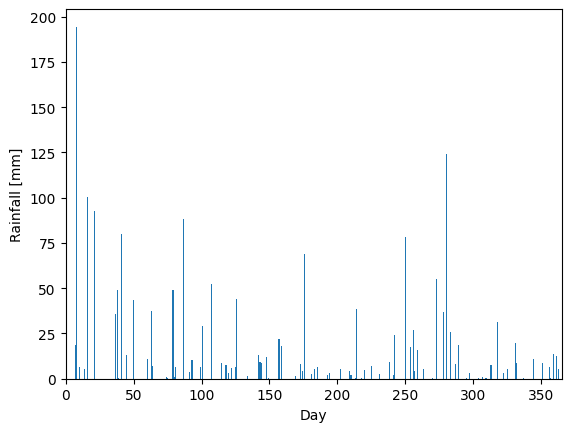

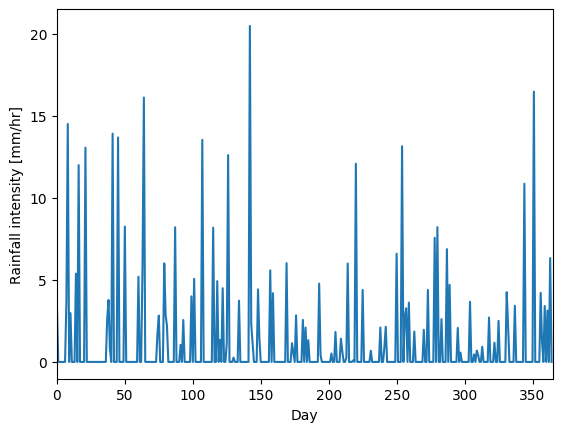

In [9]:
plt.bar(range(0,model_end), np.multiply(intensity_arr,np.multiply(dt_arr,24)))
plt.xlabel('Day')
plt.ylabel('Rainfall [mm]')
plt.xlim(0,model_end)
plt.show()

plt.plot(range(0,model_end), intensity_arr)
plt.xlabel('Day')
plt.ylabel('Rainfall intensity [mm/hr]')
plt.xlim(0,model_end)
plt.show()

#### Cross section

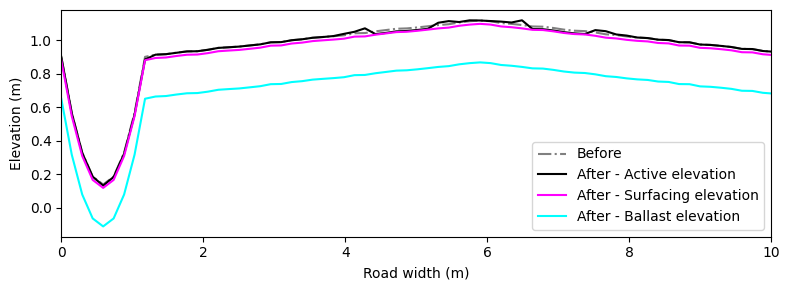

In [10]:
xsec_active = mg.at_node['active__elev'][4392*2:4428*2]
xsec_surf =  mg.at_node['surfacing__elev'][4392*2:4428*2] 
xsec_ball = mg.at_node['ballast__elev'][4392*2:4428*2]

plt.figure(figsize=(8,3), layout='tight')
plt.plot(X[36], xsec_pre, color='gray', linestyle='-.', label='Before')
plt.plot(X[36], xsec_active, color ='black', linestyle='-', label = 'After - Active elevation')
plt.plot(X[36], xsec_surf, color ='magenta', linestyle='-', label = 'After - Surfacing elevation')
plt.plot(X[36], xsec_ball, color ='cyan', linestyle='-', label = 'After - Ballast elevation ')
plt.xlim(0,10)
plt.xlabel('Road width (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.show()

#### 3D rendition of the road surface

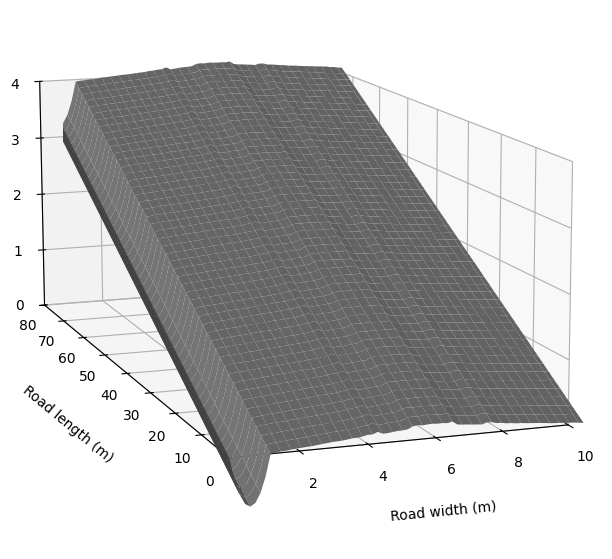

In [11]:
X = mg.node_x.reshape(mg.shape)
Y = mg.node_y.reshape(mg.shape)
Z = z.reshape(mg.shape)

fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(111, projection='3d')
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 2, 1, 1]))
ax.plot_surface(X, Y, Z, color='gray')
ax.view_init(elev=12, azim=-110)
ax.dist = 17
ax.set_xlim(0, 10)
ax.set_ylim(0, 80)
ax.set_zlim(0, 4)
ax.set_zticks(np.arange(0, 5, 1))
ax.set_xlabel('Road width (m)', labelpad=10)
ax.set_ylabel('Road length (m)', labelpad=17)
ax.set_zlabel('Elevation (m)', labelpad=10)
ax.set_zticklabels(labels=('0','1','2','3','4'))
plt.show()

#### Map

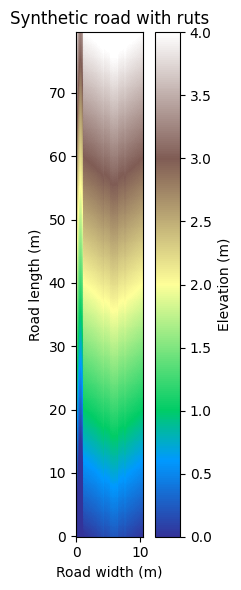

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
imshow_grid(mg, z, plot_name='Synthetic road with ruts', var_name='Elevation', var_units='m',\
    grid_units=('m', 'm'), cmap='terrain', color_for_closed='black', vmin=0, vmax=4)
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

#### Individual layer elevation changes

Note that the surfacing and the ballast are changing by *very* small amounts!

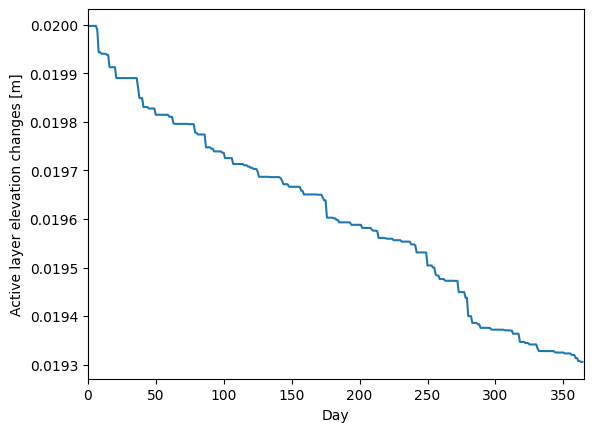

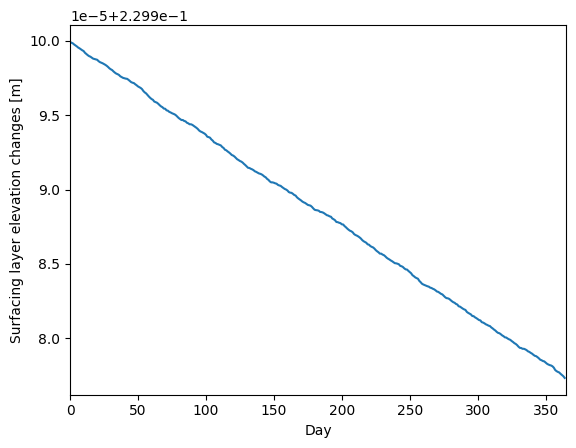

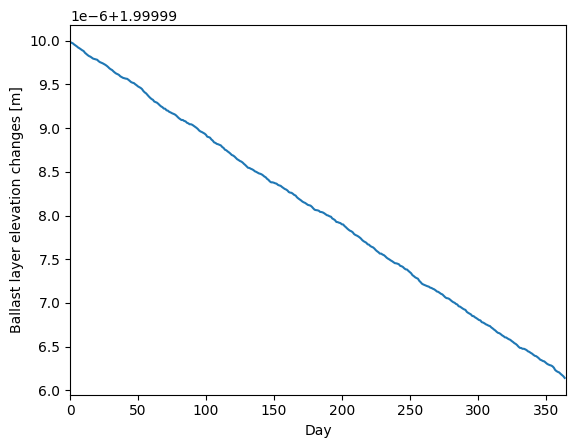

In [13]:
plt.plot(range(0,model_end), sa_arr)
plt.xlabel('Day')
plt.ylabel('Active layer elevation changes [m]')
plt.xlim(0,model_end)
plt.show()

plt.plot(range(0,model_end), ss_arr)
plt.xlabel('Day')
plt.ylabel('Surfacing layer elevation changes [m]')
plt.xlim(0,model_end)
plt.show()

plt.plot(range(0,model_end), sb_arr)
plt.xlabel('Day')
plt.ylabel('Ballast layer elevation changes [m]')
plt.xlim(0,model_end)
plt.show()

#### Cumulative elevation change and sediment load per meter of road

And here is the main goal of the model: determining the cumulative elevation change and therefore the sediment load per meter of road! This can be compared to data collected in the field.

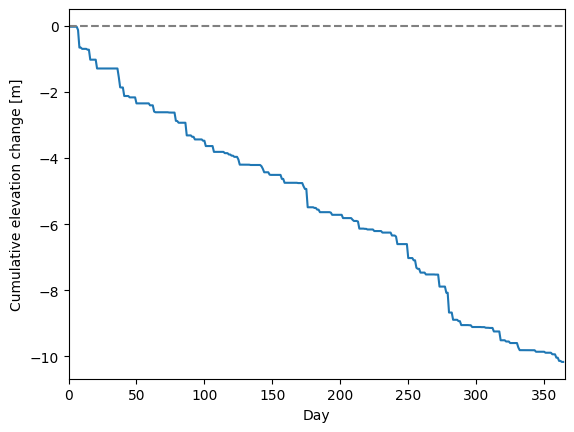

Sediment load per meter of road:  3.679826901817444


In [14]:
plt.plot(range(0,model_end), dz_arr_cum_masked)
plt.plot(range(0,model_end), np.zeros(len(range(0,model_end))), '--', color='gray')
plt.xlabel('Day')
plt.ylabel('Cumulative elevation change [m]')
plt.xlim(0,model_end)
plt.show()

total_dz = np.abs(min(dz_arr_cum_masked))
total_dV = total_dz*0.1475*0.1475
total_load = total_dV*2650
total_load_div = total_load/2
sed_load = total_load_div/(540*0.1475)

print('Sediment load per meter of road: ', sed_load)

## Start again!

### 1. Create grid using full-tire-width node spacing

In [15]:
np.random.seed(7)

mg, z, road_flag, n = ErodibleGrid(270,36,0.295,True)
noise_amplitude=0.007

z[road_flag==1] += noise_amplitude * np.random.rand(
    len(z[road_flag==1])
)

mg.at_node['active__depth'] = np.ones(270*36)*0.02
mg.at_node['surfacing__depth'] = np.ones(270*36)*0.23
mg.at_node['ballast__depth'] = np.ones(270*36)*2.0

#add absolute elevation fields that will update based on z updates
mg.at_node['active__elev'] = z
mg.at_node['surfacing__elev'] = z - mg.at_node['active__depth']
mg.at_node['ballast__elev'] = z - mg.at_node['active__depth']\
     - mg.at_node['surfacing__depth']

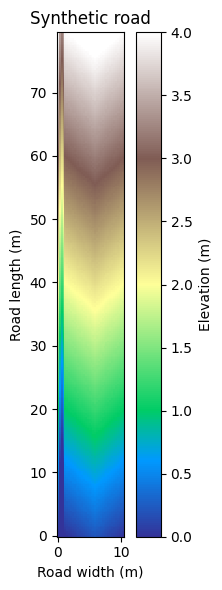

In [16]:
# Plot the initial grid
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
imshow_grid(mg, z, plot_name='Synthetic road', var_name='Elevation', var_units='m',\
    grid_units=('m', 'm'), cmap='terrain', color_for_closed='black', vmin=0, vmax=4)
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

In [17]:
# Prep some variables for later
xsec_pre = mg.at_node['topographic__elevation'][2196:2232].copy() #full tire width
mg_pre = mg.at_node['topographic__elevation'].copy()
active_pre = mg.at_node['active__depth'].copy()

X = mg.node_x.reshape(mg.shape)
Y = mg.node_y.reshape(mg.shape)
Z = z.reshape(mg.shape)

### 2. Instantiate the components

In [18]:
center = 20
half_width = 4
full_tire=True
K_sp=0.27 #erodibility in SP eqtn; this is a guess

tpe = TruckPassErosion(mg, 
                       center, 
                       half_width, 
                       full_tire, 
                       truck_num=5,
                       scat_loss=8e-5,
                       u_ps=5e-07,
                       u_pb=1e-07,
                       k_cs=1e-07,
                       k_cb=1e-07,
                       )
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     runoff_rate=1.38889e-6, #5 mm/hr converted to m/s
                     flow_director='D8',
                     )
sp = FastscapeEroder(mg, 
                     K_sp=K_sp,
                     threshold_sp=0.0,
                     discharge_field='surface_water__discharge',
                     erode_flooded_nodes=True
                     )

### 3. Define some parameters

In [19]:
mask = road_flag
z_limit = mg.at_node['topographic__elevation'] - mg.at_node['active__depth']
bottom_elev = mg.at_node['ballast__elev'].copy() - 2
intensity_arr=[]
dt_arr = []
dz_arr_masked=[]
dz_arr_cum_masked = []
sa_arr=[]
ss_arr=[]
sb_arr=[]
tracks=[]

active_depth_init = mg.at_node['active__depth']
surfacing_depth_init = mg.at_node['surfacing__depth']
ballast_depth_init = mg.at_node['ballast__depth']
z_ini_cum = mg.at_node['topographic__elevation'].copy()

#define how long to run the model
model_end = int(365) #days

### 4. Run the full model

In [20]:
np.random.seed(7)
for i in range(0, model_end): #loop through model days
    z_ini = mg.at_node['topographic__elevation'].copy()
    tpe.run_one_step()
    tracks.append(tpe.tire_tracks)
    print('Number of truck passes: ',tpe._truck_num)
    
    p_storm = 0.25
    
    chance = np.random.uniform()

    if chance > p_storm:
        intensity_arr.append(0)
        dt_arr.append(0)

        dz_cum = z-z_ini_cum
        dz_cum_masked = z[mask]-z_ini_cum[mask]
        dz_arr_cum_masked.append(sum(dz_cum_masked))

    elif chance <= p_storm:
        dt = np.random.exponential(scale=1/6)
        print('Duration of rainfall [days]: ',dt)
        dt_arr.append(dt)

        intensity = np.random.exponential(scale=5)
        print('Intensity of rainfall [mm/hr]: ', intensity)
        intensity_arr.append(intensity)

        mg.at_node['water__unit_flux_in'] = np.ones(270*36)*intensity*2.77778e-7
        fa.accumulate_flow()
        sp.run_one_step(dt)
        if any(z[tracks[i][0]] <= z_limit[tracks[i][0]]) or\
            any(z[tracks[i][1]] <= z_limit[tracks[i][1]]):
            z[tracks[i][0:2]] = z_limit[tracks[i][0:2]]
        
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
        # im = imshow_grid(mg,'surface_water__discharge', var_name='Q', 
        #              plot_name='Steady state Q, t = %i days' %i,
        #              var_units='$m^3/s$', grid_units=('m','m'), 
        #              cmap='Blues', vmin=0, vmax=5e-6, shrink=0.9)
        # plt.xlabel('Road width (m)')
        # plt.ylabel('Road length (m)')
        # plt.tight_layout()
        # # plt.savefig('output/Q_%i_days.png' %i)
        # plt.show()

        dz_cum = z-z_ini_cum
        dz_cum_masked = z[mask]-z_ini_cum[mask]
        dz_arr_cum_masked.append(sum(dz_cum_masked))
        
        # dz_cum[mask==0] = 0
        # mg.add_field('dz_cum', dz_cum, at='node', units='m', clobber=True)
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
        # plt.xlabel('Road width (m)')
        # plt.ylabel('Road length (m)')
        # im = imshow_grid(mg,'dz_cum', var_name='Cumulative dz', var_units='m', 
        #              plot_name='Elevation change, t = %i days' %i,
        #              grid_units=('m','m'), cmap='RdBu', vmin=-0.001, 
        #              vmax=0.001, shrink=0.9)
        # plt.xlabel('Road width (m)')
        # plt.ylabel('Road length (m)')
        # plt.tight_layout()
        # # plt.savefig('output/dz_cum_%i_days.png' %i)
        # plt.show()

    sa = mg.at_node['topographic__elevation'].mean()\
            - mg.at_node['surfacing__elev'].mean()
    sa_arr.append(sa)
    ss = mg.at_node['surfacing__depth'].mean()
    ss_arr.append(ss)
    sb = mg.at_node['ballast__depth'].mean()
    sb_arr.append(sb)


Number of truck passes:  6
Duration of rainfall [days]:  0.052095774084211774
Intensity of rainfall [mm/hr]:  3.464561049094261
Number of truck passes:  4
Number of truck passes:  3
Number of truck passes:  6
Number of truck passes:  5
Number of truck passes:  5
Number of truck passes:  6
Number of truck passes:  4
Duration of rainfall [days]:  0.20596470599410688
Intensity of rainfall [mm/hr]:  3.7153186603619903
Number of truck passes:  5
Duration of rainfall [days]:  0.5585964959829028
Intensity of rainfall [mm/hr]:  14.506496372964659
Number of truck passes:  5
Number of truck passes:  4
Duration of rainfall [days]:  0.08932925595240261
Intensity of rainfall [mm/hr]:  2.972129195150666
Number of truck passes:  9
Number of truck passes:  6
Number of truck passes:  6
Number of truck passes:  5
Duration of rainfall [days]:  0.04365403967110202
Intensity of rainfall [mm/hr]:  5.381687085769844
Number of truck passes:  3
Number of truck passes:  5
Duration of rainfall [days]:  0.3488570

### 5. Examine the results

#### Stochastically generated rainfall

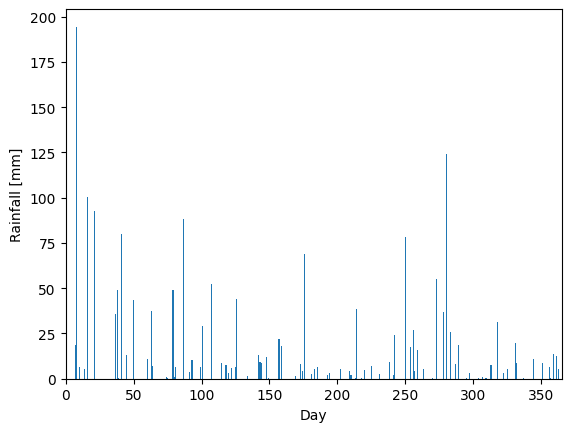

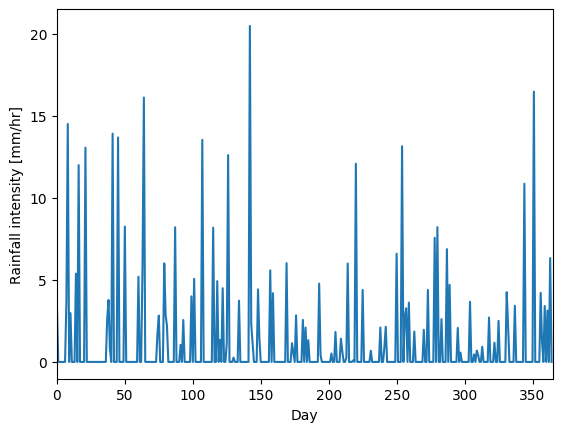

In [21]:
plt.bar(range(0,model_end), np.multiply(intensity_arr,np.multiply(dt_arr,24)))
plt.xlabel('Day')
plt.ylabel('Rainfall [mm]')
plt.xlim(0,model_end)
plt.show()

plt.plot(range(0,model_end), intensity_arr)
plt.xlabel('Day')
plt.ylabel('Rainfall intensity [mm/hr]')
plt.xlim(0,model_end)
plt.show()

#### Cross section

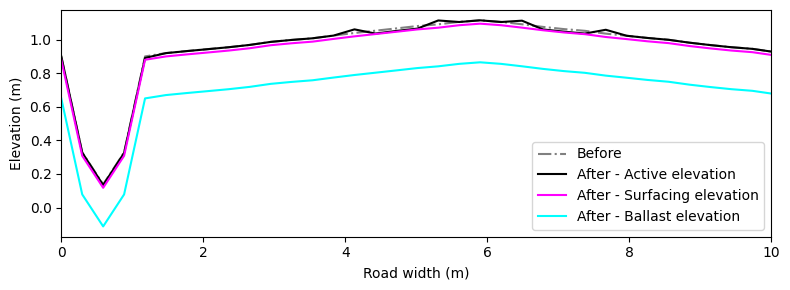

In [22]:
xsec_active = mg.at_node['active__elev'][2196:2232]
xsec_surf =  mg.at_node['surfacing__elev'][2196:2232] 
xsec_ball = mg.at_node['ballast__elev'][2196:2232]

plt.figure(figsize=(8,3), layout='tight')
plt.plot(X[36], xsec_pre, color='gray', linestyle='-.', label='Before')
plt.plot(X[36], xsec_active, color ='black', linestyle='-', label = 'After - Active elevation')
plt.plot(X[36], xsec_surf, color ='magenta', linestyle='-', label = 'After - Surfacing elevation')
plt.plot(X[36], xsec_ball, color ='cyan', linestyle='-', label = 'After - Ballast elevation ')
plt.xlim(0,10)
plt.xlabel('Road width (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.show()

#### 3D rendition of the road surface

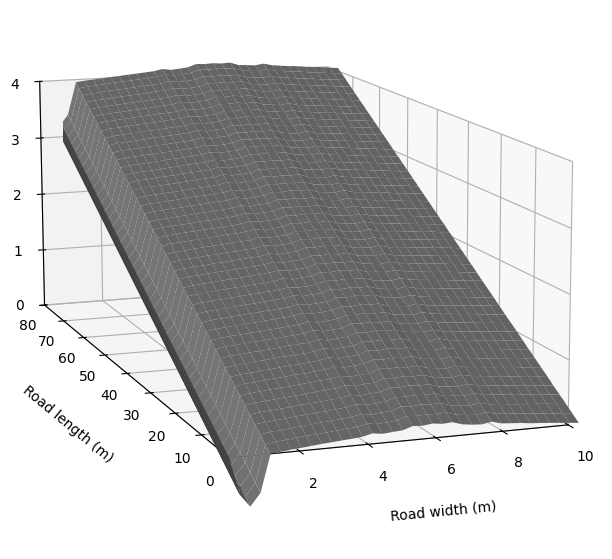

In [23]:
X = mg.node_x.reshape(mg.shape)
Y = mg.node_y.reshape(mg.shape)
Z = z.reshape(mg.shape)

fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(111, projection='3d')
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 2, 1, 1]))
ax.plot_surface(X, Y, Z, color='gray')
ax.view_init(elev=12, azim=-110)
ax.dist = 17
ax.set_xlim(0, 10)
ax.set_ylim(0, 80)
ax.set_zlim(0, 4)
ax.set_zticks(np.arange(0, 5, 1))
ax.set_xlabel('Road width (m)', labelpad=10)
ax.set_ylabel('Road length (m)', labelpad=17)
ax.set_zlabel('Elevation (m)', labelpad=10)
ax.set_zticklabels(labels=('0','1','2','3','4'))
plt.show()

#### Map

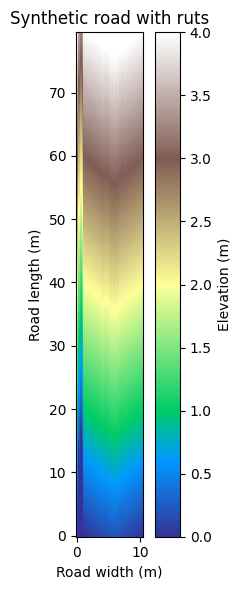

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
imshow_grid(mg, z, plot_name='Synthetic road with ruts', var_name='Elevation', var_units='m',\
    grid_units=('m', 'm'), cmap='terrain', color_for_closed='black', vmin=0, vmax=4)
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

#### Individual layer elevation changes

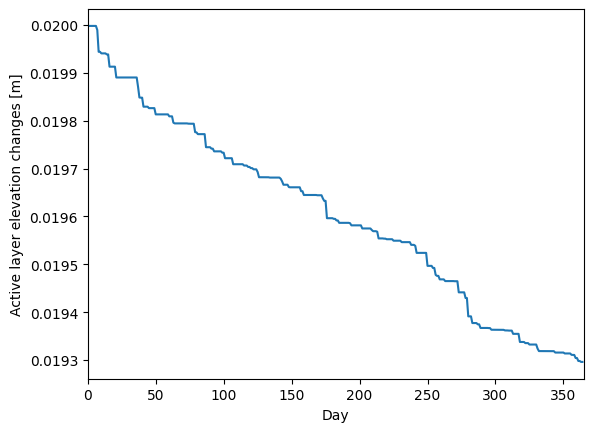

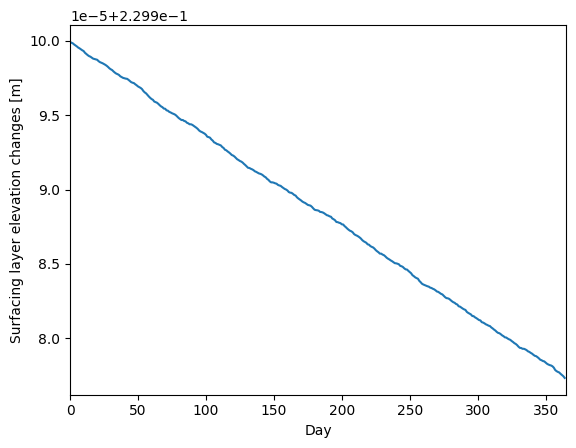

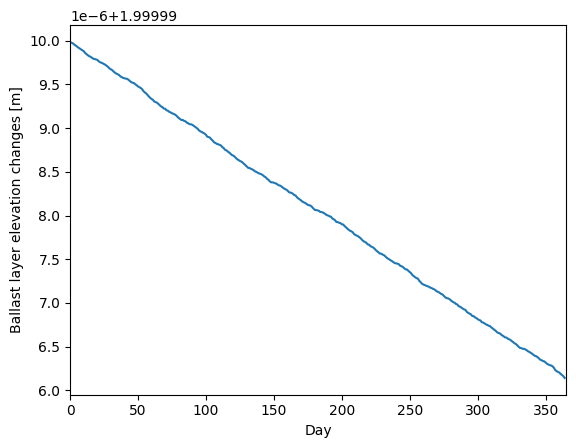

In [25]:
plt.plot(range(0,model_end), sa_arr)
plt.xlabel('Day')
plt.ylabel('Active layer elevation changes [m]')
plt.xlim(0,model_end)
plt.show()

plt.plot(range(0,model_end), ss_arr)
plt.xlabel('Day')
plt.ylabel('Surfacing layer elevation changes [m]')
plt.xlim(0,model_end)
plt.show()

plt.plot(range(0,model_end), sb_arr)
plt.xlabel('Day')
plt.ylabel('Ballast layer elevation changes [m]')
plt.xlim(0,model_end)
plt.show()

#### Cumulative elevation change and sediment load per meter of road

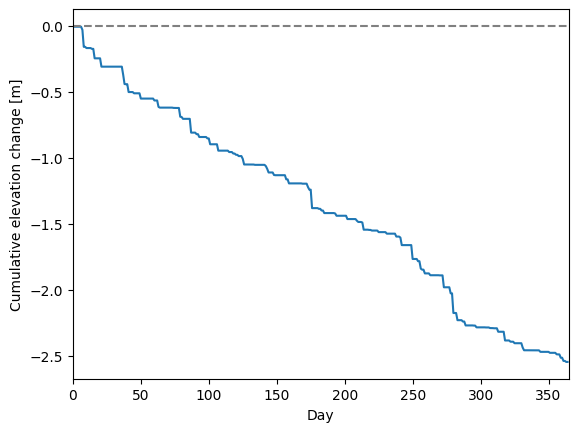

Sediment load per meter of road:  3.6873217554979045


In [26]:
plt.plot(range(0,model_end), dz_arr_cum_masked)
plt.plot(range(0,model_end), np.zeros(len(range(0,model_end))), '--', color='gray')
plt.xlabel('Day')
plt.ylabel('Cumulative elevation change [m]')
plt.xlim(0,model_end)
plt.show()

total_dz = np.abs(min(dz_arr_cum_masked))
total_dV = total_dz*0.295*0.295
total_load = total_dV*2650
total_load_div = total_load/2
sed_load = total_load_div/(270*0.295)

print('Sediment load per meter of road: ', sed_load)